In [53]:
%reload_ext autoreload
%autoreload 2

In [54]:


import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt 
import optax

from markovsbi.tasks import get_task
from markovsbi.utils.sde_utils import init_sde
from markovsbi.models.simple_scoremlp import build_score_mlp, precondition_functions, precondition_functions_v3, precondition_functions_v2
from markovsbi.models.train_utils import build_batch_sampler,build_loss_fn

from markovsbi.bm.plot_utils import use_style

In [55]:
jax.devices()

[cuda(id=0)]

In [56]:
key = jax.random.PRNGKey(1)

In [57]:
task = get_task("simple1dstationary")
prior = task.get_prior()
simulator = task.get_simulator()

In [58]:
data = task.get_data(key, 1_000_000, 2)

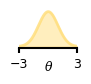

In [59]:
x = jnp.linspace(-3, 3, 1000)
pdf = jnp.exp(jax.vmap(prior.log_prob)(x))

color = "#ffdf7fd9"

with use_style("pyloric"):
    fig = plt.figure(figsize=(.75, .5))
    ax = plt.gca()
    plt.plot(x, pdf, color=color, lw=2)
    plt.fill_between(x, pdf, color=color, alpha=0.5)
    # Disable y axis
    ax.axes.get_yaxis().set_visible(False)
    # Disable y spines
    ax.spines["left"].set_visible(False)
    plt.xlim(-3, 3)
    plt.xticks([-3, 3])
    plt.xlabel(r"$\theta$", labelpad=-8)
    fig.savefig("prior.svg", bbox_inches="tight", pad_inches=0, transparent=True)
    
fig

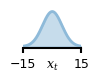

In [60]:
x = jnp.linspace(-15, 15, 1000)
pdf = jnp.exp(jax.vmap(lambda x: jax.scipy.stats.norm.logpdf(x, 0., 5.))(x))

color2 = "#8ebad9ff"

with use_style("pyloric"):
    fig = plt.figure(figsize=(.75, .5))
    ax = plt.gca()
    plt.plot(x, pdf, color=color2, lw=2)
    plt.fill_between(x, pdf, color=color2, alpha=0.5)
    # Disable y axis
    ax.axes.get_yaxis().set_visible(False)
    # Disable y spines
    ax.spines["left"].set_visible(False)
    plt.xlim(-15, 15)
    plt.xticks([-15, 15])
    plt.xlabel(r"$x_t$", labelpad=-8)
    fig.savefig("proposal.svg", bbox_inches="tight", pad_inches=0, transparent=True)
    
fig

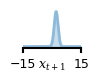

In [9]:
x = jnp.linspace(-15, 15, 1000)
pdf = jnp.exp(jax.vmap(lambda x: jax.scipy.stats.norm.logpdf(x, 2., 1.))(x))

color2 = "#8ebad9ff"

with use_style("pyloric"):
    fig = plt.figure(figsize=(.75, .5))
    ax = plt.gca()
    plt.plot(x, pdf, color=color2, lw=2)
    plt.fill_between(x, pdf, color=color2, alpha=0.5)
    # Disable y axis
    ax.axes.get_yaxis().set_visible(False)
    # Disable y spines
    ax.spines["left"].set_visible(False)
    plt.xlim(-15, 15)
    plt.xticks([-15, 15])
    plt.xlabel(r"$x_{t+1}$", labelpad=-8)
    fig.savefig("transition.svg", bbox_inches="tight", pad_inches=0, transparent=True)
    
fig

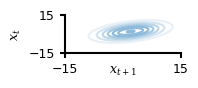

In [47]:
x = jnp.linspace(-15, 15, 500)
y = jnp.linspace(-15, 15, 500)
xx, yy = jnp.meshgrid(x, y)
pos = jnp.dstack((xx, yy))
pos = jnp.reshape(pos, (500*500, 2))
L = jnp.array([[1., 1.], [0., 1.]])
cov = jnp.dot(L, L.T) + jnp.eye(2)
pdf = jax.vmap(lambda x: jax.scipy.stats.multivariate_normal.pdf(x, 2*jnp.ones(2),10*cov))(pos)

import matplotlib.colors as mcolors

# Your specified color
color2 = "#8ebad9ff"

# Create a custom colormap that transitions from white to color2
colors = ["white", color2]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

with use_style("pyloric"):
    fig = plt.figure(figsize=(1.5, .5))
    ax = plt.gca()
    plt.contour(xx,yy,pdf.reshape(500,500), origin="lower", extent=(-15, 15, -15, 15), cmap=cmap, vmax=0.005)
    plt.xticks([-15, 15])
    plt.yticks([-15, 15])
    plt.xlabel(r"$x_{t+1}$", labelpad=-8)
    plt.ylabel(r"$x_{t}$")
    fig.savefig("transition2d.svg", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()

In [61]:
pdf.min()

Array(0.001, dtype=float32)

In [62]:
sde, weight_fn = init_sde(data)

In [63]:
sde.std(sde.T_min)

Array(0.039, dtype=float32, weak_type=True)

In [64]:
key, key_init = jax.random.split(key)

In [65]:
c_in, c_noise, c_out = precondition_functions_v2(sde)
init_fn, score_net = build_score_mlp(2, num_hidden=5, c_in=c_in, c_noise=c_noise, c_out=c_out)
batch_sampler = build_batch_sampler(data)
loss_fn = build_loss_fn("dsm", score_net, sde,weight_fn, control_variate=False, control_variate_cutoff=1.)

In [66]:
theta_batch, x_batch = batch_sampler(key_init, 10)
d = theta_batch.shape[1]
print(theta_batch.shape, x_batch.shape)

(10, 1) (10, 2, 1)


In [67]:
params = init_fn(key_init, jnp.ones((10,)), theta_batch, x_batch)

In [68]:
score_net(params, jnp.ones((10,)), theta_batch, x_batch).shape

(10, 1, 1)

In [103]:
loss_fn(params, key,theta_batch, x_batch)

Array(29.565, dtype=float32)

In [104]:

schedule = optax.cosine_onecycle_schedule (
    100_000, 1e-4,
)
optimizer = optax.chain(optax.adaptive_grad_clip(100), optax.adamw(schedule))
opt_state = optimizer.init(params)

In [105]:
@jax.jit
def update(params, rng, opt_state, theta_batch, x_batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng, theta_batch, x_batch)
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [106]:
for i in range(10):
    l = 0.
    for _ in range(10000):
        key, key_batch = jax.random.split(key)
        theta_batch, x_batch = batch_sampler(key_batch, 1000)
        loss, params, opt_state = update(params, key, opt_state, theta_batch, x_batch)
        l += loss/10000
    print(l)

6.549075
6.3933725
6.3584175
6.3702493
6.389399
6.361944
6.3505454
6.3405023
6.3318152
6.351687


In [69]:
from markovsbi.sampling.score_fn import FNPEScoreFn, UncorrectedScoreFn, GaussCorrectedScoreFn,CorrectedScoreFn, ScoreFn

In [70]:
score_fn = FNPEScoreFn(score_net, params, sde, prior)
score_fn = UncorrectedScoreFn(score_net, params, sde,prior)
score_fn = GaussCorrectedScoreFn(score_net, params, sde, prior, posterior_precission_est_fn=lambda x: 2.0)
#score_fn = CorrectedScoreFn(score_net, params, sde, prior)

In [71]:
key = jax.random.PRNGKey(5)
theta_o = prior.sample(key)
num_obs = 101
x_o = simulator(key, theta_o, num_obs)
print(theta_o)

[0.343]


In [72]:
from markovsbi.bm.plot_utils import use_style

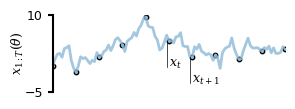

In [79]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(3., 1.))
    plt.plot(x_o, lw=2, color=color2, alpha=0.8)
    plt.savefig("x_o.svg")
    # Disable x_axis
    plt.gca().axes.get_xaxis().set_visible(False)
    # # Disable x spine 
    plt.gca().spines['bottom'].set_visible(False)
    plt.xlabel("Time", labelpad=0.5)
    plt.ylabel(r"$x_{1:T}(\theta)$", labelpad=-0.5)
    plt.yticks([-5,10])
    plt.xticks([0,100])
    plt.ylim(-5,10)
    plt.xlim(0,100)
    plt.text(50, x_o[50,0] - 5, r"$x_t$", fontsize=9)
    plt.text(60, x_o[60,0] - 5, r"$x_{t+1}$", fontsize=9)
    
    # Line connecting x_t and point on line 
    plt.plot([49, 49], [x_o[50,0], x_o[50,0] - 5], color="black", lw=0.5)
    plt.plot([59, 59], [x_o[60,0], x_o[60,0] - 5], color="black", lw=0.5)

    plt.scatter(jnp.arange(0, 101, 10), x_o[::10], color=color2, s=10, edgecolors='black')
    
    fig.savefig("x_o.svg")
fig

In [112]:

from markovsbi.sampling.sample import Diffuser
from markovsbi.sampling.kernels import EulerMaruyama, PredictorCorrector, DDIM
 
kernel = EulerMaruyama(score_fn)
time_grid = jnp.linspace(sde.T_min, sde.T_max, 500)
sampler = Diffuser(kernel, time_grid, (d,))


In [113]:
import torch
import numpy as np

samples1 = jax.vmap(sampler.sample, in_axes=(0, None))(jax.random.split(key, 5000), x_o[:11])
true_posterior1 = task.get_true_posterior(x_o[:11])
true_posterior2 = task.get_true_posterior(x_o)
x  = jnp.linspace(-1,1,1000)
pdf1 = jnp.exp(jax.vmap(true_posterior1.log_prob)(x))
pdf2 = jnp.exp(jax.vmap(true_posterior2.log_prob)(x))


In [114]:
samples2 = jax.vmap(sampler.sample, in_axes=(0, None))(jax.random.split(key, 1000), x_o)

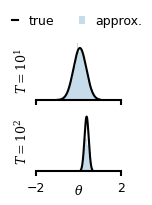

In [122]:
with use_style("pyloric"):
    fig, axes = plt.subplots(2,figsize=(1.1, 1.7))
    axes[0].hist(samples1, bins=50, density=True, alpha=0.5, color=color2)
    axes[0].plot(x, pdf1, color="black")
    axes[0].set_xticklabels([])
    axes[0].set_ylabel(r"$T=10^1$")
    axes[0].spines['left'].set_visible(False)
    #axes[0].vlines(theta_o, 0, 4, color="grey")
    axes[0].set_xlim(-2,2)
    axes[0].set_yticks([])
    axes[0].set_yticklabels([])
    
    axes[1].hist(samples2, bins=50, density=True, alpha=0.5, color=color2)
    #axes[1].vlines(theta_o, 0, 12, color="grey")
    axes[1].plot(x, pdf2, color="black")
    axes[1].set_ylabel(r"$T=10^2$")
    axes[1].set_xlabel("$\\theta$", labelpad=-8)
    axes[1].spines['left'].set_visible(False)
    axes[1].set_yticks([])
    axes[1].set_yticklabels([])
    axes[1].set_xlim(-2,2)
    axes[1].set_xticks([-2,2])
    axes[0].set_xticks([-2,2])  
    fig.legend(["true","approx."], ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1.1), handlelength=.5)
    
    
    plt.savefig("samples.svg")

fig